In [1]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import euclidean

df= pd.read_csv('dataset_diabetes/diabetic_data.csv')

In [2]:
import numpy as np
df.replace({'?':np.nan},inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
null_feature=[i for i in df.columns if df[i].isnull().sum()>=1]
print('Null features {} \n'.format(null_feature))
print('Feature \t null_count \t not_null_count')
for i in null_feature:
    print('{} \t {} \t\t {}'.format(i,df[i].isnull().sum(),df[i].count()))

Null features ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'] 

Feature 	 null_count 	 not_null_count
race 	 2273 		 99493
weight 	 98569 		 3197
payer_code 	 40256 		 61510
medical_specialty 	 49949 		 51817
diag_1 	 21 		 101745
diag_2 	 358 		 101408
diag_3 	 1423 		 100343


In [4]:
#Dropping columns with count of null values around the count of not null values. As they dont provide significant information or 
#mostly contains null data
df.drop(['weight','payer_code','medical_specialty'],axis=1,inplace=True)


In [5]:
df['age'] = df['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95})

In [6]:
df['readmitted'] = df['readmitted'].replace({'>30':1,'<30':1,'NO':0})


In [7]:
for i in df.select_dtypes(include=['int', 'float']).columns.to_list():
    print('The numeric feature is {} \n The value counts are {}'.format(i,df[i].value_counts()) )

The numeric feature is encounter_id 
 The value counts are 2278392      1
190792044    1
190790070    1
190789722    1
190786806    1
            ..
106665324    1
106657776    1
106644876    1
106644474    1
443867222    1
Name: encounter_id, Length: 101766, dtype: int64
The numeric feature is patient_nbr 
 The value counts are 88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64
The numeric feature is age 
 The value counts are 75    26068
65    22483
55    17256
85    17197
45     9685
35     3775
95     2793
25     1657
15      691
5       161
Name: age, dtype: int64
The numeric feature is admission_type_id 
 The value counts are 1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64
The numeric feature is discharge_disposition_id 
 The value co

In [8]:
df.drop(columns=['encounter_id','patient_nbr'],inplace=True,axis=1)

In [9]:
meds=['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
      'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
      'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
      'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
df_value_counts=pd.DataFrame()
for i in meds:
    value_counts=df[i].value_counts()
    percent = []
    for j in value_counts.index:
        percent.append(value_counts[j] *100/ len(df))
    ## PErcentage dataframe to store the feature, its unique values, the count and the percentage
    df_temp=pd.DataFrame({'Feature':i,'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percent})
    df_value_counts=pd.concat([df_value_counts,df_temp],ignore_index=True)
df_value_counts.head(80)  

,Feature,Value,Count,Percentage
0,max_glu_serum,None,96420,94.746772
1,max_glu_serum,Norm,2597,2.551933
2,max_glu_serum,>200,1485,1.459230
3,max_glu_serum,>300,1264,1.242065
4,A1Cresult,None,84748,83.277322
...,...,...,...,...
74,glimepiride-pioglitazone,Steady,1,0.000983
75,metformin-rosiglitazone,No,101764,99.998035
76,metformin-rosiglitazone,Steady,2,0.001965
77,metformin-pioglitazone,No,101765,99.999017


In [10]:
skewed_data=df_value_counts[df_value_counts['Percentage']>95]['Feature'].to_list()
df.drop(columns=skewed_data,inplace=True)

In [11]:
label_encoded_columns=[]
for i in df.select_dtypes(include=['object']).columns.to_list():
    if i not in skewed_data:
        label_encoded_columns.append(i)
## The columns remaining after all the EDA that are to be label encoded

In [12]:
df_cleaned_dia=df.copy()
## creating the copy of data before performing label encoding and one hot encoding
one_hot = pd.get_dummies(df_cleaned_dia[['gender','race']])
label_encoded_columns.remove('diag_1')
label_encoded_columns.remove('diag_2')
label_encoded_columns.remove('diag_3')
label_encoded_columns.remove('gender')
label_encoded_columns.remove('race')
# combine the one-hot encoded columns with the original dataframe
df_cleaned_dia = pd.concat([df_cleaned_dia, one_hot], axis=1)
df_cleaned_dia.drop(columns=['diag_1','diag_2','diag_3','gender','race'],inplace=True)
##
df_cleaned_dia[label_encoded_columns]=df_cleaned_dia[label_encoded_columns].swifter.apply(LabelEncoder().fit_transform)

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
df_cleaned_dia.shape

(101766, 32)

In [16]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import warnings



def PCA(df,threshold):
    ## Performing Standardization so that all features are given same importance initially and each feature can contribute
    ## equally to PC irrespective of scale or magnitude
    df =pd.DataFrame(StandardScaler().fit_transform(df))
    ## Performing Data Centering on standardized dataframe
    centred_df= df-np.mean(df,axis=0)
    ## Calculating Covariance 
    covariance=np.cov(df.T)
    eigen_values, eigen_vectors = LA.eig(covariance)
    ## Sorting the eigen values in descending order, using argsort, we get the indices of eigen values in descending order
    sorted_index=eigen_values.argsort()[::-1]
    df_variance=pd.DataFrame(eigen_values[sorted_index]/sum(eigen_values),columns=['variance'])
    df_variance['cumulative_variance']= df_variance['variance'].cumsum()
    ## Number of principal components required to cover variance uptill certian threshold
    df_number_pc_var=df_variance[df_variance['cumulative_variance']<= threshold]
    number_of_pc=len(df_number_pc_var)
    print("The number of principal components required to cover {} percent variance are {}".format(threshold*100,number_of_pc))
    ## Selecting the required number of eigen vectores for performing dot product
    selected_eigen_vectors=eigen_vectors[:,sorted_index[:number_of_pc]]
    
    #Projecting data over the selected number of principal components
    principal_component=centred_df.dot(selected_eigen_vectors) #Performing dot product
    principal_component.columns=[f'PC{i+1}' for i in range(number_of_pc)]
    ## Creating Scree plots
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the first subplot of variance on the left side
    axes[0].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['variance'],'ro-', linewidth=2)
    axes[0].set_title('Scree Plot for Variance')
    axes[0].set_ylabel('Variance')
    axes[0].set_xlabel('Number of Principal Component')


    # Plot the second subplot of cumulative variance on the right side
    axes[1].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['cumulative_variance'],'ro-', linewidth=2)
    axes[1].set_title('Scree Plot for Cumulative Variance')
    axes[1].set_ylabel('Cumulative Variance')
    axes[1].set_xlabel('Number of Principal Component')

    plt.show()
    print('Correlation of PC1,PC2 \n',principal_component[['PC1','PC2']].corr())
    plt.scatter(principal_component['PC1'],principal_component['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Scatter plot of PC1 VS PC2')
    plt.show()
    print('The Total variance explained by PC1,PC2 is {} percent'.format(round(np.real(df_number_pc_var['cumulative_variance'][1])*100,2)))
    
    loadings = pd.DataFrame(selected_eigen_vectors,index=df.columns)
    warnings.filterwarnings("ignore")
    
    return principal_component,loadings,df_variance,df_number_pc_var,eigen_values, eigen_vectors

The number of principal components required to cover 90.0 percent variance are 24


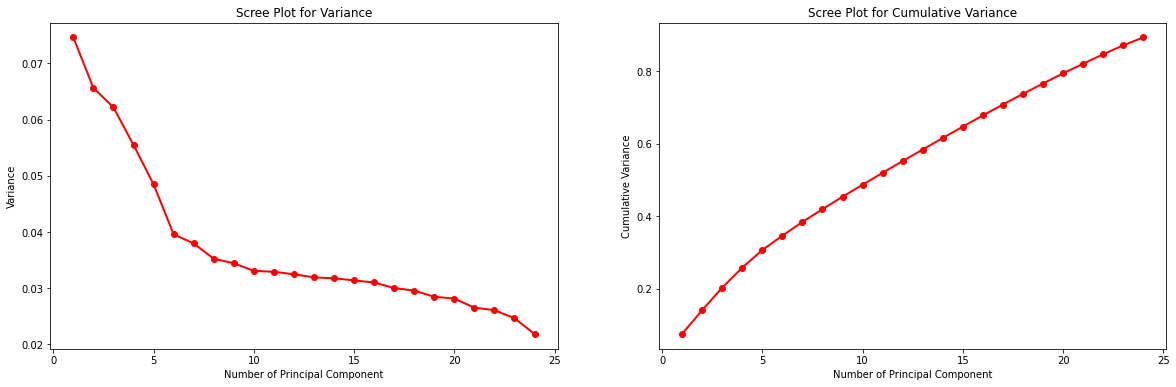

Correlation of PC1,PC2 
               PC1           PC2
PC1  1.000000e+00  9.690675e-17
PC2  9.690675e-17  1.000000e+00


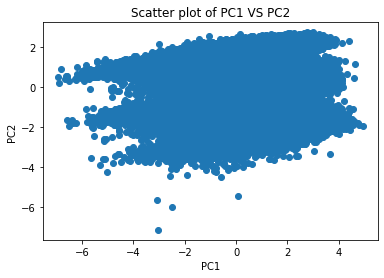

The Total variance explained by PC1,PC2 is 14.02 percent


In [17]:
principal_component,loadings,df_variance,df_number_pc_var,eigen_values, eigen_vectors=PCA(df_cleaned_dia,0.9)


In [21]:
df_cleaned_dia= pd.DataFrame(np.real(principal_component.values), columns=principal_component.columns)

In [22]:
df_cleaned_dia

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,3.672430,-0.034377,0.201868,1.224605,1.877240,3.354428,0.701063,0.009101,-1.966560,0.279663,...,0.493735,0.243375,-3.444950,0.815473,-0.715160,-0.547009,0.855121,-2.513595,1.263346,0.915125
1,-0.548340,-1.177522,-0.290131,0.832073,-0.877733,-0.508227,1.492488,1.543255,-0.716665,-0.195154,...,-0.489849,0.265336,0.579016,0.675764,0.300525,0.509909,-0.122931,-1.676224,-0.328405,2.051335
2,1.749622,-2.123027,-1.785704,-0.420758,0.381760,1.399144,1.600068,-0.122976,1.393667,1.643519,...,0.115180,-0.143566,0.495211,-1.368273,-0.706020,-0.113541,-0.442292,0.840866,1.053871,2.447084
3,-0.138539,1.424058,-1.592962,0.271287,-0.099597,-0.454923,1.047722,1.126779,-0.302303,-0.315712,...,-0.692969,0.351812,0.316559,0.543800,-0.857451,0.350229,0.313511,-0.731435,0.016104,1.226664
4,0.483901,1.639272,-1.945303,1.101246,-0.254319,-0.782867,0.329647,1.643469,0.770926,1.290402,...,-0.130644,0.047062,-0.118702,0.652973,-0.756392,-0.060121,-0.054426,-0.298062,1.580622,0.773079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,-0.209812,-0.345267,-2.458051,-1.069636,-0.622964,-1.397677,-1.456097,-0.188856,-0.541113,0.267587,...,0.954525,-0.364148,0.102480,-1.163357,0.646380,-0.264399,-1.129268,0.556696,-1.897775,-0.159305
101762,0.499058,-2.389755,-0.067465,-1.416989,0.718521,-0.504660,-0.358169,-0.766306,0.928640,-0.079081,...,-0.598112,0.223951,0.091698,-0.275756,-0.214400,-0.007536,0.108361,1.301034,-0.547850,-0.027564
101763,-0.563821,1.739193,-0.233065,0.593350,-0.683856,-1.910772,-1.069110,-0.329330,0.164276,0.044475,...,0.125201,-0.366322,1.280646,-0.756597,-1.626085,-0.403009,-0.762096,0.345651,-1.813306,0.570352
101764,-2.844650,-1.023174,0.706981,0.956109,0.528057,-0.408982,-0.212290,0.987505,2.913306,-0.551291,...,-0.376818,0.238941,-0.272571,0.559938,-0.262892,0.576355,1.580496,0.381403,0.307450,-0.691920


In [23]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import euclidean


def GMM_initialization(df,k):
    number_of_rows=df.shape[0]
    number_of_columns=df.shape[1]
    means_matrix = df.sample(n=k).values
    identity_matrix=np.eye(number_of_columns)
    covariance_matrix=np.array([identity_matrix]*k)
    weights_matrix=np.array([float(1/k)]*k)
    return means_matrix,covariance_matrix,weights_matrix,number_of_rows,number_of_columns
    
    
def calculate_posterior(data,means_matrix,covariance_matrix,weights_matrix,k,number_of_columns):
    posterior=np.zeros(k)
    for i in range(k):
        try:
            pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.eye(covariance_matrix[i].shape[0]) * 1e-2, rcond=1e-10)
            posterior[i] = multivariate_normal.pdf(data, mean=means_matrix[i], cov=pseudo_inverse)
        except Exception as e:
            continue
    return posterior*weights_matrix/(posterior*weights_matrix).sum()
    
def maintain_k_clusters(labels,k):
    unique_values, value_counts = np.unique(labels, return_counts=True)
    missing_labels=[i for i in range(k) if i not in unique_values]
    unique_values_to_be_replaced=[unique_values[i] for i in np.where(value_counts > 1)[0]]

    indices=[i for i in range(len(labels))    if labels[i] in unique_values_to_be_replaced]
    random_indices = np.random.choice(indices, size=len(missing_labels), replace=False)
    for i,val in enumerate(random_indices):
        labels[val]=missing_labels[i]
    return labels


def sum_of_square_error_em(new_centroids, data, labels):
    columns = data.columns
    # Join the data dataframe and the labels dataframe
    data = data.join(labels)
    # Rename the '0' column of the labels dataframe to 'Label'
    data.rename(columns={0:'Label'}, inplace=True)
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns],dtype=np.float64), axis=1)
        #print(distance)
        sse.append(distance.sum())
    # Return the sum of squared errors
    
    a=sum(sse)   
    return a

def Calinski_index_em(df_data,clusters):
    ch_score = calinski_harabasz_score(df_data, clusters)
    return ch_score
    


def GMM(df_cleaned_dia,k,tao):
    scaler = StandardScaler()
    scaler.fit(df_cleaned_dia)
    scaled_input=scaler.transform(df_cleaned_dia)
    
    scaled_input_df= pd.DataFrame(scaled_input,columns=df_cleaned_dia.columns)
    
    means_matrix,covariance_matrix,weights_matrix,number_of_rows,number_of_columns= GMM_initialization(scaled_input_df,k)
    likelihood=0
    means_matrix_initial=means_matrix
    for i in range(k):
        try:
            
            pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.diag(np.ones(covariance_matrix[i].shape[0]) * 1e-10))
            likelihood=likelihood+weights_matrix[i]*multivariate_normal.logpdf(scaled_input,means_matrix[i], pseudo_inverse)
        except Exception as e:
            continue
    log_likelihood_old=np.sum(likelihood)
    old_means_matrix_df=pd.DataFrame(means_matrix)
    posterior_probability = np.zeros((scaled_input.shape[0], k))
    iterations=0
    
    while (True):
        iterations+=1
        # Expectation
        for i in range(scaled_input.shape[0]):
            posterior_probability[i] = calculate_posterior(scaled_input[i], means_matrix,covariance_matrix,weights_matrix,k,number_of_columns)
        
        # Maximization
        posterior_probability=np.nan_to_num(posterior_probability, nan=0)
        for i in range(k): 
            # Calculating weight
            weight = posterior_probability[:, i].sum()
            #print(weight)
            # Updating each centroid
            means_matrix[i] = (posterior_probability[:, i] @ scaled_input) / weight
            #print(1,means_matrix[i])
            # Subtracting the mean value from data
            scaled_input_diff = scaled_input - means_matrix[i]

            # Update the covariance matrix 
            covariance_matrix[i] = (posterior_probability[:, i] * scaled_input_diff.T @ scaled_input_diff) / weight

            # Update the weights matrix
            weights_matrix[i] = weight / number_of_rows
        

        likelihood=0
        for i in range(k):
            try:
                pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.diag(np.ones(covariance_matrix[i].shape[0]) * 1e-10))
                likelihood=likelihood+weights_matrix[i]*multivariate_normal.logpdf(scaled_input,means_matrix[i], sudo_inverse)
            except Exception as e:
                continue
        log_likelihood_new =np.sum(likelihood)
        
        new_means_matrix_df=pd.DataFrame(means_matrix)
        distance = []
        for col in new_means_matrix_df.columns:
            col_distance = euclidean(old_means_matrix_df[col], new_means_matrix_df[col])
            distance.append(col_distance)
        tao_calculated=sum(distance)/k 
        
        
        
        if tao_calculated< tao:#log_likelihood_new>log_likelihood_old and 100*((log_likelihood_new - log_likelihood_old) / log_likelihood_old)<tao:
            
            print("Converged")
            labels=np.argmax(posterior_probability,axis=1)
            labels=maintain_k_clusters(labels,k)
            labels_df=pd.DataFrame(labels)
            means_matrix_df=pd.DataFrame(means_matrix,columns=scaled_input_df.columns)
            sse=sum_of_square_error_em(means_matrix_df, scaled_input_df, labels_df)
            clainski= Calinski_index_em(scaled_input_df,labels_df)
            return sse,clainski,means_matrix_initial
        #else:
            #log_likelihood_old=log_likelihood_new
            
        if iterations>100:
            print("Max iteration reached")
            labels=np.argmax(posterior_probability,axis=1)
            labels=maintain_k_clusters(labels,k)
            labels_df=pd.DataFrame(labels)
            means_matrix_df=pd.DataFrame(means_matrix,columns=scaled_input_df.columns)
            sse=sum_of_square_error_em(means_matrix_df, scaled_input_df, labels_df)
            clainski= Calinski_index_em(scaled_input_df,labels_df)
            return sse,clainski,means_matrix_initial
        
    


In [24]:
#sse,clainski,means_matrix_initial=GMM(df_cleaned_dia,2,10)

Converged


In [27]:
import time
from scipy.spatial.distance import euclidean
def initialize_centroids(df, k,means_matrix):
    """
    Function to initialize random centroids from dataset.
    Input: 
        - df: pandas dataframe with the data
        - k: integer number of clusters
    Output: 
        - temp_df: pandas dataframe with the centroids as columns and index as label
    """
    
   
    centroids=pd.DataFrame(means_matrix,columns=df.columns)
    centroids=centroids.T
    centroids.index.name = 'Label'
    return centroids



def assign_labels(df, centroids):
    """
    Function to calculate the closest centroid label for each row in a dataframe.
    Input: 
        - df: pandas dataframe with the data
        - centroids: pandas dataframe with the centroids as columns and index as label
    Output: 
        - distances.idxmin(axis=1): pandas series with the label of the closest centroid for each row in df
    """
    distances = centroids.swifter.apply(lambda x: np.sqrt(((df - x) ** 2).sum(axis=1))) # Calculate the Euclidean distance between each row in df and each centroid
    return distances.idxmin(axis=1) # Get the index of the minimum distance, which corresponds to the label of the closest centroid


def new_centroids(df_label, df1):
    """
    Function to calculate the new centroids based on the current labels of the rows.
    Input: 
        - df_label: pandas series with the label of the closest centroid for each row in df1
        - df1: pandas dataframe with the data
    Output: 
        - new_centroids.T: pandas dataframe with the new centroids as columns and index as feature name
    """
    joined_df = df1.join(df_label)
    joined_df.rename(columns={0: 'Label'}, inplace=True) # Rename the column with the label
    # Calculate the mean of the rows with the same label
    return joined_df.groupby('Label').mean().T # Transpose the dataframe to have the new centroids as columns and index as feature name



def error_clusters(df_new_centroids,df1,df_label):
    """
    Calculate the error rate of each cluster.

    Args:
    - df_label (pandas.DataFrame): the label of the nearest centroid for each data point.
    - df1 (pandas.DataFrame): the dataset.
    - df_new_centroids (pandas.DataFrame): The new centroids computed in the current iteration.

    Returns:
    - error_rate (float): the total error rate of all clusters.
    """
    

    #Calculate mean value 
    mean_centroid=df1.groupby('readmitted').mean().reset_index()
    # Transpose the new centroids dataframe and reset the index
    new_centroids= df_new_centroids.T
    # Get the columns of the data dataframe
    columns = df1.columns

    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):   #### centroid
        s=[]
        for j in range(len(mean_centroid)): ### mean centroid
        # Compute the distance between each data point and its assigned centroid
            distance = np.sum(np.square(mean_centroid[mean_centroid['readmitted']==j][columns] - new_centroids.iloc[i][columns]), axis=1)
            s.append(distance.iloc[0])
        sse.append(s)
    ## key  is the cluster number and value is the merged value
    merge_label=pd.DataFrame(sse).idxmin(axis=1).to_dict() 
    ## Merging cluster based on the target variable
    df_label[0]=df_label[0].replace(merge_label)
    
    df1 = df1.join(df_label) # add the label column to the dataset
    df1.rename(columns={0: 'Label'}, inplace=True) # rename the label column
    error_list = []
    for i in df1['Label'].value_counts().index:
        df_cluster = df1[df1['Label'] == i] # filter the dataset to include only the data points in the current cluster
        y = len(df_cluster[df_cluster['readmitted'] == 1]) # count the number of data points in the current cluster that were readmitted
        n = len(df_cluster[df_cluster['readmitted'] == 0]) # count the number of data points in the current cluster that were not readmitted
        if y == 0 and n == 0:
            error = 0
        else:
            error = n / (n + y) # calculate the error rate of the current cluster
        error_list.append(error)
    return round(sum(error_list),4)


def sum_of_square_error(new_centroids, data, labels):
    """
    Computes the sum of squared errors between the data points and their assigned centroids.

    Args:
    new_centroids (DataFrame): The new centroids computed in the current iteration.
    data (DataFrame): The input data points.
    labels (DataFrame): The labels assigned to each data point.

    Returns:
    The sum of squared errors.
    """
    # Transpose the new centroids dataframe and reset the index
    new_centroids = new_centroids.T.reset_index()
    # Get the columns of the data dataframe
    columns = new_centroids.columns
    # Join the data dataframe and the labels dataframe
    data = data.join(labels)
    # Rename the '0' column of the labels dataframe to 'Label'
    data.rename(columns={0:'Label'}, inplace=True)
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns]), axis=1)
        sse.append(sum(distance))
    # Return the sum of squared errors
    return sum(sse)   

def Calinski_index(df_data,clusters):
    ch_score = calinski_harabasz_score(df_data, clusters)
    return ch_score
    



def kmeans_lyod_with_error(df1, k, tou,means_matrix_initial):
    """
    Function to run the K-means Lloyd algorithm.
    Input: 
        - df1: pandas dataframe with the data
        - k: integer number of clusters
        - tou: float tolerance level to stop the algorithm
    Output: 
        - centroids: pandas dataframe with the final centroids as columns and index as label
    """
    start_time=time.time()
    centroids = initialize_centroids(df1, k,means_matrix_initial) # Initialize random centroids
    initial_list_of_columns = centroids.columns.to_list()
    iteration = 0
    while True:
        # Assign labels to current centroids
        df_label = assign_labels(df1, centroids)
        df_label = pd.DataFrame(df_label)
        # Calculate new centroids
        df_new_centroids = new_centroids(df_label, df1)
        new_list_of_columns = df_new_centroids.columns.to_list()
        # Keep the number of clusters the same i.e maintain same k
        for i in initial_list_of_columns:
            if i not in new_list_of_columns:
                df_new_centroids[i] = centroids[i]
        # Calculate tao
        distance = []
        for col in centroids.columns:
            col_distance = euclidean(centroids[col], df_new_centroids[col])
            distance.append(col_distance)
        tao_calculated=sum(distance)/k #Used the formula provided for calculating Tao
        sse = sum_of_square_error(df_new_centroids, df1, df_label)
        #error=error_clusters(df_label,df1,k)
        end_time= time.time()
        clainski= Calinski_index(df1,df_label)
        if iteration>100:  
            print("Iteration exceeded")

            return sse,clainski
            break
            
        if tao_calculated<tou or iteration >100:   #if the convergence is met, kmeans will stop  or else if the convergence is never met, after 100 iteration code will stop 
            return  sse,clainski
            break                                   # otherwise indefinite loop
        else:
            centroids= df_new_centroids # In case we need more iterations, the centroids calculated at this step acts as input
        iteration+=1



In [28]:
#kmeans_lyod_with_error(df_cleaned_dia,2,10,means_matrix_initial)

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

(2816365.0065882765, 3373.9458544870076)

In [30]:
error_matrix_em=[]
error_matrix_kmeans=[]
for i in range(2,6):
    for j in range(1,21):
        sse,clainski,means_matrix_initial=GMM(df_cleaned_dia,2,10)
        error_matrix_em.append([i,sse,clainski])
        
        sse,clainski=kmeans_lyod_with_error(df_cleaned_dia,2,10,means_matrix_initial)
        error_matrix_kmeans.append([i,sse,clainski])
error_df_em= pd.DataFrame(error_matrix_em,columns=['number_of_cluster', 'sse','clainski'])  
error_df_kmeans= pd.DataFrame(error_matrix_kmeans,columns=['number_of_cluster', 'sse','clainski']) 


Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Converged


Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
error_df_em.to_csv('6_em_pca.csv',index=False)
error_df_kmeans.to_csv('6_kmeans_pca.csv',index=False)

In [32]:

error_df_em['algo']='em'
error_df_kmeans['algo']='kmeans'


run_time_diab=pd.DataFrame()
run_time_diab=pd.concat( [ error_df_em[['algo','number_of_cluster','sse','clainski']],
    error_df_kmeans[['algo','number_of_cluster', 'sse','clainski']]
                        ],ignore_index=True )

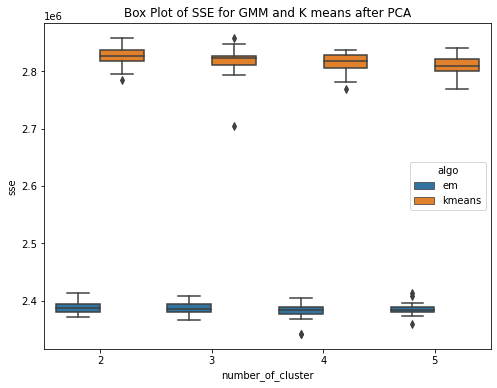

In [37]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='sse', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['kmeans','em'])],ax=ax);
plt.title('Box Plot of SSE for GMM and K means after PCA')
plt.show()

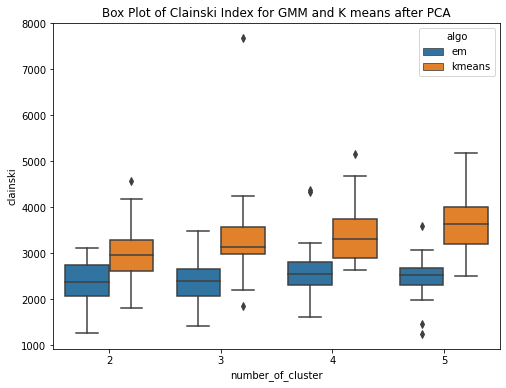

In [36]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='clainski', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['kmeans','em'])],ax=ax);
plt.title('Box Plot of Clainski Index for GMM and K means after PCA')
plt.show()

In [40]:
error_df_em_nopca=pd.read_csv('6_em.csv')
error_df_kmeans_nopca=pd.read_csv('6_kmeans.csv')


error_df_em_nopca['algo']='em_nopca'
error_df_kmeans_nopca['algo']='kmeans_nopca'


In [41]:
run_time_diab=pd.concat( [ run_time_diab[['algo','number_of_cluster','sse','clainski']],
    error_df_em_nopca[['algo','number_of_cluster', 'sse','clainski']],
    error_df_kmeans_nopca[['algo','number_of_cluster', 'sse','clainski']]                     
                        ],ignore_index=True )

In [42]:
run_time_diab

,algo,number_of_cluster,sse,clainski
0,em,2,2.386529e+06,2443.070471
1,em,2,2.392537e+06,2127.101075
2,em,2,2.377747e+06,2778.852718
3,em,2,2.383451e+06,2546.146508
4,em,2,2.380266e+06,2723.831036
...,...,...,...,...
315,kmeans_nopca,5,2.871580e+06,3410.239661
316,kmeans_nopca,5,2.795329e+06,4197.218665
317,kmeans_nopca,5,2.841665e+06,3713.951295
318,kmeans_nopca,5,2.945306e+06,2688.059677


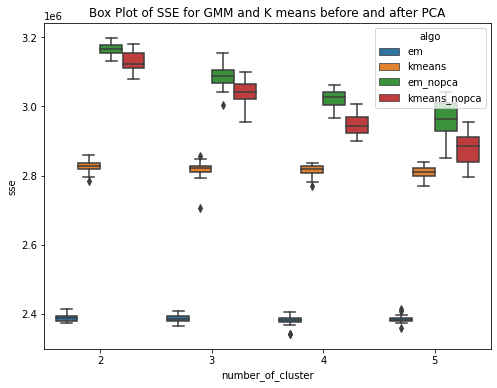

In [43]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='sse', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['kmeans','em','kmeans_nopca','em_nopca'])],ax=ax);
plt.title('Box Plot of SSE for GMM and K means before and after PCA')
plt.show()

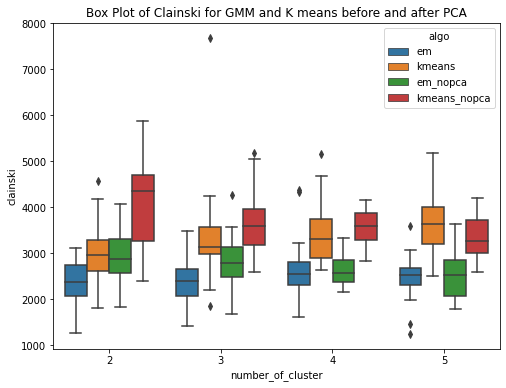

In [44]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='clainski', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['kmeans','em','kmeans_nopca','em_nopca'])],ax=ax);
plt.title('Box Plot of Clainski for GMM and K means before and after PCA')
plt.show()